In [1]:
# Import the dependencies.
# Mandatory
from sqlalchemy import create_engine, text, inspect

# ORM imports - for classes
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import create_engine, func, case
from sqlalchemy.orm import Session
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import create_engine

#data science
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Other imports
import datetime as dt

# Import DB credentials
import config as cfg

import os

import plotly.express as px

## Connecting to Postgres

In [2]:
# Setup the SQL connection variables
SQL_USERNAME = cfg.SQL_USERNAME
SQL_PASSWORD = cfg.SQL_PASSWORD
SQL_IP = cfg.SQL_IP
SQL_PORT = cfg.SQL_PORT
DATABASE = cfg.DATABASE

In [3]:
# Connect to PostgreSQL server
connection_string = f'postgresql+psycopg2://{SQL_USERNAME}:{SQL_PASSWORD}@{SQL_IP}:{SQL_PORT}/{DATABASE}'
engine = create_engine(connection_string)

In [4]:
query_simple = "SELECT * FROM unemployment LIMIT 5;"
simple_df = pd.read_sql(query_simple, engine)
print(simple_df)

  id  fips econ_year  unemp_rate  num_unemployed                last_update
0  1     0      2020         8.1      12933704.0 2024-08-11 12:48:47.993954
1  2  1000      2020         5.9        131056.0 2024-08-11 12:48:47.993954
2  3  1001      2020         4.9          1262.0 2024-08-11 12:48:47.993954
3  4  1003      2020         5.6          5425.0 2024-08-11 12:48:47.993954
4  5  1005      2020         7.0           605.0 2024-08-11 12:48:47.993954


In [32]:
# Connect to PostgreSQL server using SQLAlchemy
connection_string = f'postgresql+psycopg2://{SQL_USERNAME}:{SQL_PASSWORD}@{SQL_IP}:{SQL_PORT}/{DATABASE}'
try:
    engine = create_engine(connection_string)
    print("Database connection established successfully.")
except Exception as e:
    print(f"Error connecting to the database: {e}")
    engine = None

if engine:
    
    # Define SQL query for unemployment data
    query_unemployment = """
                        SELECT
                            u.econ_state,
                        	u.econ_year,
                            s.name AS state_name,
                            s.latitude,
                            s.longitude,
                            COALESCE(u.tot_num_unemployed, 0) AS total_unemployed
                        FROM
                            (
                            SELECT
                                j.econ_state,
                        		u.econ_year,
                                SUM(u.num_unemployed) AS tot_num_unemployed
                            FROM
                                unemployment u
                            JOIN
                                jobs j
                            ON u.fips = j.fips
                            WHERE
                                CAST(u.econ_year AS INTEGER) > 2010
                            GROUP BY
                                j.econ_state, u.econ_year
                            ) AS u
                        JOIN
                            state s
                        ON u.econ_state = s.econ_state
                        ORDER BY
                            u.econ_state, u.econ_year;
    """

    # Define SQL query for employment data
    query_employment = """
                       SELECT
                        e.econ_state,
                    	e.econ_year,
                        s.name AS state_name,
                        s.latitude,
                        s.longitude,
                        COALESCE(e.tot_num_employed, 0) AS total_employed
                    FROM
                        (
                        SELECT
                            j.econ_state,
                    		e.econ_year,
                            SUM(e.num_employed) AS tot_num_employed
                        FROM
                            employment e
                        JOIN
                            jobs j
                        ON e.fips = j.fips
                        WHERE
                            CAST(e.econ_year AS INTEGER) > 2010
                        GROUP BY
                            j.econ_state, e.econ_year
                        ) AS e
                    JOIN
                        state s
                    ON e.econ_state = s.econ_state
                    ORDER BY
                        e.econ_state, e.econ_year;
    """

    try:
        # Load the query results into DataFrames using SQLAlchemy engine
        unemployment_df = pd.read_sql(query_unemployment, engine)
        employment_df = pd.read_sql(query_employment, engine)

        # Display the first few rows to verify the data
        print("Unemployment Data:")
        print(unemployment_df.head())
        print("\nEmployment Data:")
        print(employment_df.head())


    except Exception as e:
        print(f"Error executing query or generating visualizations: {e}")

else:
    print("Database connection was not established.")

Database connection established successfully.
Unemployment Data:
  econ_state econ_year state_name   latitude   longitude  total_unemployed
0         AK      2014     Alaska  63.588753 -154.493062           49157.0
1         AK      2015     Alaska  63.588753 -154.493062           45640.0
2         AK      2016     Alaska  63.588753 -154.493062           47647.0
3         AK      2017     Alaska  63.588753 -154.493062           46996.0
4         AK      2018     Alaska  63.588753 -154.493062           42333.0

Employment Data:
  econ_state econ_year state_name   latitude   longitude  total_employed
0         AK      2014     Alaska  63.588753 -154.493062        679410.0
1         AK      2015     Alaska  63.588753 -154.493062        679208.0
2         AK      2016     Alaska  63.588753 -154.493062        676390.0
3         AK      2017     Alaska  63.588753 -154.493062        675458.0
4         AK      2018     Alaska  63.588753 -154.493062        670065.0


In [46]:
query_total= """
SELECT state.econ_state,
		econ_year,
		name,
		latitude,
		longitude,
		tot_num_employed,
		tot_num_unemployed,
		tot_pctemp_agriculture,
		tot_pctemp_mining,
		tot_pctemp_construction,
		tot_pctemp_manufacturing,
		tot_pctemp_trade,
		tot_pctemp_trans,
		tot_pctemp_information,
		tot_pctemp_fire,
		tot_pctemp_services,
		tot_pctemp_government,
		tot_um_civ_labor_force
FROM
	(
	SELECT
        jobs.econ_state,
    	employment.econ_year,
    	sum(num_employed) as tot_num_employed,
    	sum(num_unemployed) as tot_num_unemployed,
        sum(pctemp_agriculture) as tot_pctemp_agriculture,
        sum(pctemp_mining)as tot_pctemp_mining,
        sum(pctemp_construction) as tot_pctemp_construction,
        sum(pctemp_manufacturing) as tot_pctemp_manufacturing,
        sum(pctemp_trade) as tot_pctemp_trade,
        sum(pctemp_trans) as tot_pctemp_trans,
        sum(pctemp_information) as tot_pctemp_information,
        sum(pctemp_fire) as tot_pctemp_fire,
        sum(pctemp_services) as tot_pctemp_services,
        sum(pctemp_government) as tot_pctemp_government,
        sum(num_civ_labor_force) as tot_um_civ_labor_force
	FROM
    	jobs
	JOIN
    	employment
	ON jobs.fips = employment.fips
	JOIN
		unemployment
    ON employment.fips = unemployment.fips
    AND employment.econ_year = unemployment.econ_year
	WHERE
    	CAST(employment.econ_year AS INTEGER) > 2010
		and jobs.econ_state <> 'US'
	GROUP BY
		jobs.econ_state,
		employment.econ_year
	ORDER BY
    	jobs.econ_state,
		employment.econ_year
	) AS JOBS
JOIN
	state ON JOBS.econ_state = state.econ_state
ORDER BY
	econ_state,
	econ_year
 "

SyntaxError: incomplete input (2442369132.py, line 1)

In [47]:
unemployment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   econ_state        371 non-null    object 
 1   econ_year         371 non-null    object 
 2   state_name        371 non-null    object 
 3   latitude          371 non-null    float64
 4   longitude         371 non-null    float64
 5   total_unemployed  371 non-null    float64
dtypes: float64(3), object(3)
memory usage: 17.5+ KB


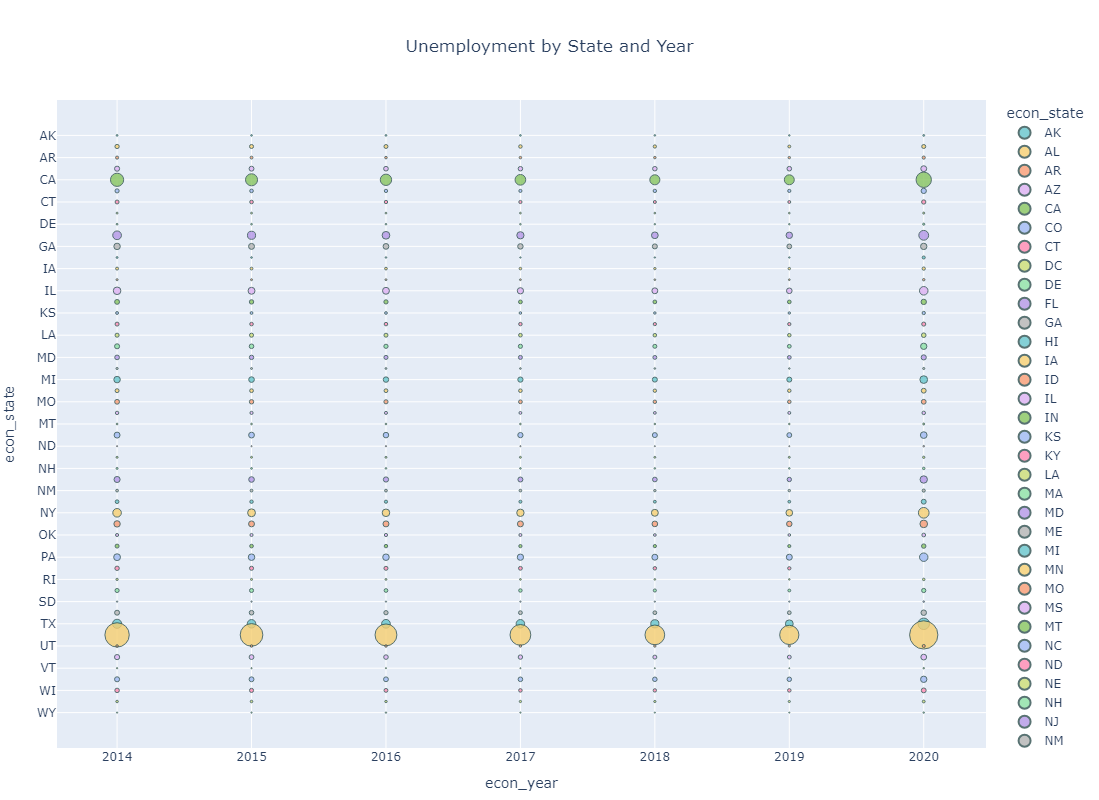

In [48]:
fig = px.scatter(unemployment_df,
                 x='econ_year',
                 y='econ_state',
                 size='total_unemployed',
                 hover_name='econ_state',
                 color='econ_state',  # Use 'econ_state' to assign colors
                 title='Unemployment by State and Year',
                 color_discrete_sequence=px.colors.qualitative.Pastel)  # Apply the pastel color sequence

# Update layout for better aesthetics
fig.update_layout(
    width=1000,  # Set the width of the figure
    height=800,  # Set the height of the figure
    title={
        'text': "Unemployment by State and Year",
        'y':0.95,  # Title position
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    margin=dict(l=50, r=50, t=100, b=50),  # Adjust margins
    paper_bgcolor='white',  # Set background color
)

# Update traces for better appearance
fig.update_traces(
    marker=dict(
        opacity=0.8,  # Make markers slightly transparent
        line=dict(width=1, color='DarkSlateGrey')  # Add border to markers
    )
)

fig.show()


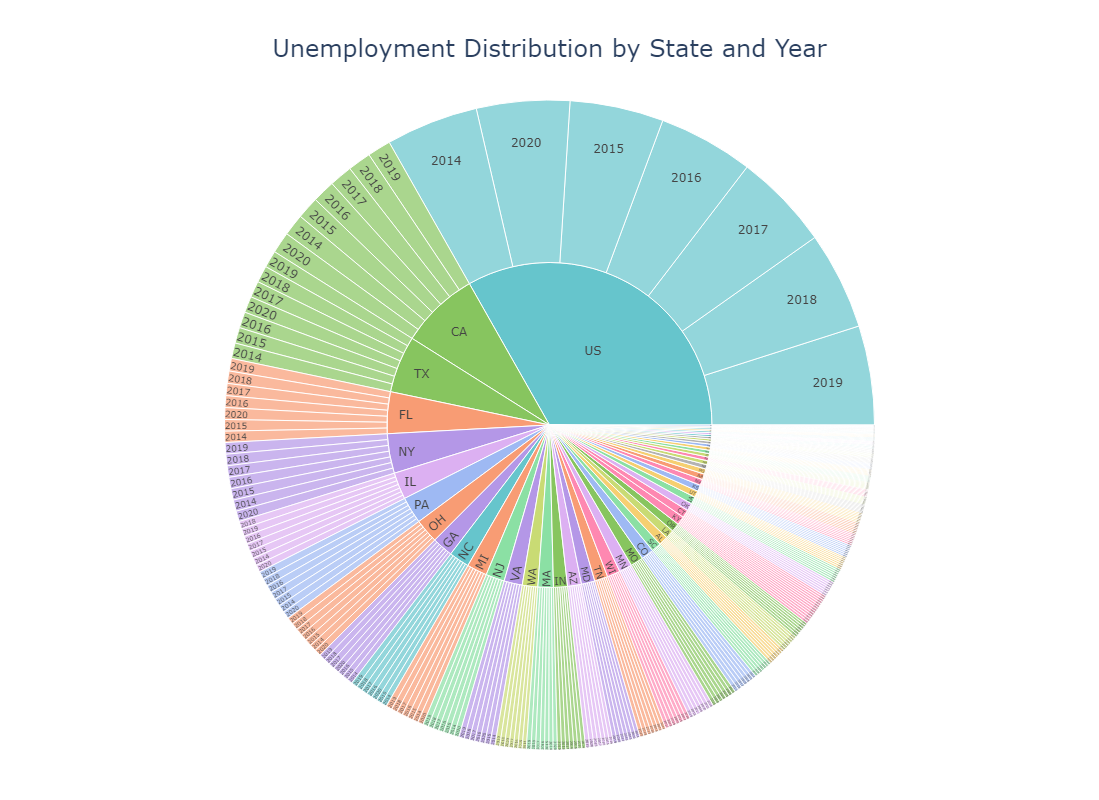

In [45]:
fig = px.sunburst(employment_df,
                  path=['econ_state', 'econ_year'],
                  values='total_employed',
                  color='econ_state',  # Specify the column to color by
                  title='Unemployment Distribution by State and Year',
                  color_discrete_sequence=px.colors.qualitative.Pastel)  # Use a predefined color sequence

# Update the layout to change the size of the figure and style the title
fig.update_layout(
    width=800,  # Set the width of the figure
    height=800,  # Set the height of the figure
    title={
        'text': "Unemployment Distribution by State and Year",
        'y':0.95,  # Position title near the top
        'x':0.5,  # Center the title
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 24}  # Increase the font size of the title
    },
    margin=dict(l=50, r=50, t=100, b=50)  # Adjust margins for better appearance
)

fig.show()


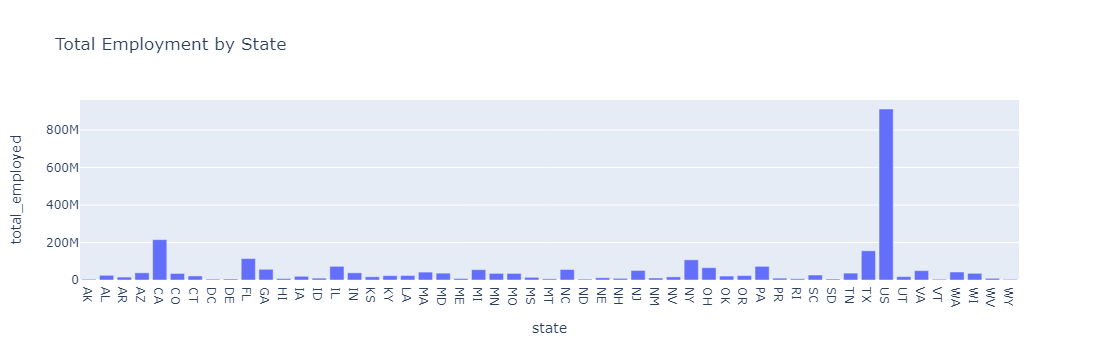

In [19]:
# Bar Chart for Employment by State
statewise_employment = employment_df.groupby('state')['total_employed'].sum().reset_index()

fig = px.bar(statewise_employment,
             x='state',
             y='total_employed',
             title='Total Employment by State')

fig.show()


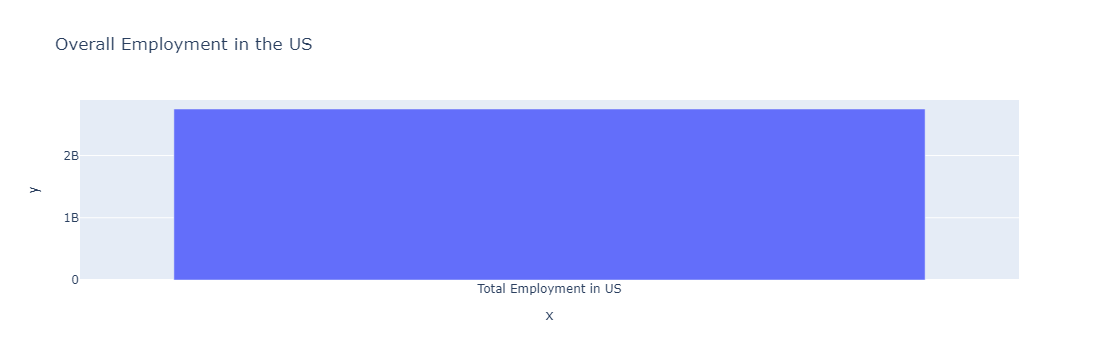

In [20]:
# Overall Employment in the US
total_employment = employment_df['total_employed'].sum()

fig = px.bar(x=['Total Employment in US'],
             y=[total_employment],
             title='Overall Employment in the US')

fig.show()


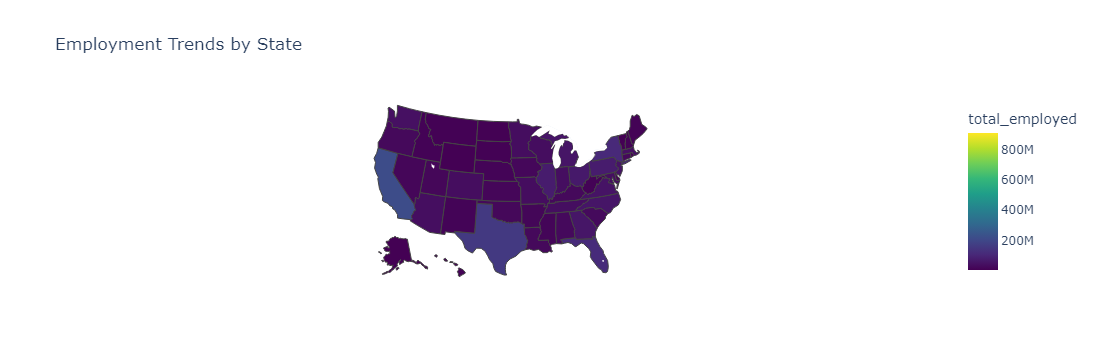

In [24]:
# Create a choropleth map
fig = px.choropleth(
    employment_df,
    locations='state',  # The column in your DataFrame with state abbreviations
    locationmode='USA-states',  # Use state abbreviations for the map
    color='total_employed',  # The data to represent
    hover_name='state',  # Information to show on hover
    color_continuous_scale='Viridis',  # Choose a color scale
    scope="usa",  # Limit the map scope to the United States
    title='Employment Trends by State'
)

# Update the layout for better visuals
fig.update_layout(
    geo=dict(
        lakecolor='rgb(255, 255, 255)',
    )
)

# Show the figure
fig.show()

In [31]:
# explore and understand the data

# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Collect the names of tables within the database
tables = inspector.get_table_names()

# Using the inspector to print the column names within each table and its types
for table in tables:
    print(table)
    columns = inspector.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])
        
    print()

income
fips VARCHAR(5)
state VARCHAR(2)
county VARCHAR(40)
median_hh_inc_acs NUMERIC
percapita_inc NUMERIC
poverty_rate_0_17_acs NUMERIC
poverty_rate_acs NUMERIC
deep_pov_all NUMERIC
deep_pov_children NUMERIC
num_allinpov_acs NUMERIC
pct_pov_0_17 NUMERIC
pov_0_17 NUMERIC
med_hh_inc NUMERIC
pov_all NUMERIC
pct_pov_all NUMERIC
num_in_pov_0_17_acs NUMERIC
last_update TIMESTAMP

jobs
fips VARCHAR(5)
state VARCHAR(2)
county VARCHAR(40)
pctemp_agriculture NUMERIC
pctemp_mining NUMERIC
pctemp_construction NUMERIC
pctemp_manufacturing NUMERIC
pctemp_trade NUMERIC
pctemp_trans NUMERIC
pctemp_information NUMERIC
pctemp_fire NUMERIC
pctemp_services NUMERIC
pctemp_government NUMERIC
num_civ_employed NUMERIC
last_update TIMESTAMP

unemployment
id VARCHAR(8)
fips VARCHAR(5)
year VARCHAR(4)
unemp_rate NUMERIC
num_unemployed NUMERIC
last_update TIMESTAMP

employment
id VARCHAR(8)
fips VARCHAR(5)
year VARCHAR(4)
num_civ_labor_force NUMERIC
num_employed NUMERIC
last_update TIMESTAMP



## Single DataFrame combining all 4 tables (contacts, campaigns, categories and subcategories)

#### Method 1: SQL Statement

In [7]:
#Join of all 4 tables to create a full dataframe
#This query selects data from contact (cont), campaign (camp), category (cat) and subcategory (sub)
#The from clause specifies from which tables which includes joining of tables on the key. 
#In our database, we will join the jobs table to the employment table using fips (that's what they have in common).  That's what the ALTER TABLE statement tells us when we created the tables.
# This statement joins 4 tables together to get all the data needed
query = """
        SELECT
                	state,
                    county,
        			employment.year,
        			num_employed,
        			num_unemployed,
                    pctemp_agriculture,
                    pctemp_mining,
                    pctemp_construction,
                    pctemp_manufacturing,
                    pctemp_trade,
                    pctemp_trans,
                    pctemp_information,
                    pctemp_fire,
                    pctemp_services,
                    pctemp_government,
                    num_civ_labor_force
        FROM
            jobs
        JOIN
            employment
            ON jobs.fips = employment.fips
        JOIN
            unemployment
            ON employment.fips = unemployment.fips
            AND employment.year = unemployment.year
        WHERE
            CAST(employment.year AS INTEGER) > 2014
        	and state <> 'US'
        ORDER BY 
            jobs.state, jobs.county, employment.year
		;
		"""

full_data_sql_df = pd.read_sql(text(query), con=engine)
full_data_sql_df.head()

,state,county,year,num_employed,num_unemployed,pctemp_agriculture,pctemp_mining,pctemp_construction,pctemp_manufacturing,pctemp_trade,pctemp_trans,pctemp_information,pctemp_fire,pctemp_services,pctemp_government,num_civ_labor_force
0,AK,Alaska,2015,339604.0,22821.0,1.760339,2.970895,6.72937,3.784067,12.789628,8.334148,2.087563,3.525565,46.359705,11.658721,362425.0
1,AK,Alaska,2016,338193.0,23824.0,1.760339,2.970895,6.72937,3.784067,12.789628,8.334148,2.087563,3.525565,46.359705,11.658721,362017.0
2,AK,Alaska,2017,337728.0,23497.0,1.760339,2.970895,6.72937,3.784067,12.789628,8.334148,2.087563,3.525565,46.359705,11.658721,361225.0
3,AK,Alaska,2018,335033.0,21166.0,1.760339,2.970895,6.72937,3.784067,12.789628,8.334148,2.087563,3.525565,46.359705,11.658721,356199.0
4,AK,Alaska,2019,334754.0,19134.0,1.760339,2.970895,6.72937,3.784067,12.789628,8.334148,2.087563,3.525565,46.359705,11.658721,353888.0


In [8]:
#Join of all 4 tables to create a full dataframe
#This query selects data from contact (cont), campaign (camp), category (cat) and subcategory (sub)
#The from clause specifies from which tables which includes joining of tables on the key. 
#In our database, we will join the jobs table to the employment table using fips (that's what they have in common).  That's what the ALTER TABLE statement tells us when we created the tables.
# This statement joins 4 tables together to get all the data needed
query = """
		SELECT
			cont.first_name,
			cont.last_name,
			cont.email,
			camp.company_name,
			camp.description,
			camp.goal,
			camp.pledged,
			camp.outcome,
			camp.backers_count,
			camp.country,
			camp.currency,
			camp.launched_date,
			camp.end_date,
			camp.staff_pick,
			camp.spotlight,
			cat.category,
			sub.subcategory
		FROM
			public.campaign camp
		JOIN public.contact cont
			ON camp.contact_id = cont.contact_id
		JOIN public.category cat
			ON camp.category_id = cat.category_id
		JOIN public.subcategory sub
			ON camp.subcategory_id = sub.subcategory_id
		;
		"""

full_data_sql_df = pd.read_sql(text(query), con=engine)
full_data_sql_df.head()

ProgrammingError: (psycopg2.errors.UndefinedTable) relation "public.campaign" does not exist
LINE 21:    public.campaign camp
            ^

[SQL: 
		SELECT
			cont.first_name,
			cont.last_name,
			cont.email,
			camp.company_name,
			camp.description,
			camp.goal,
			camp.pledged,
			camp.outcome,
			camp.backers_count,
			camp.country,
			camp.currency,
			camp.launched_date,
			camp.end_date,
			camp.staff_pick,
			camp.spotlight,
			cat.category,
			sub.subcategory
		FROM
			public.campaign camp
		JOIN public.contact cont
			ON camp.contact_id = cont.contact_id
		JOIN public.category cat
			ON camp.category_id = cat.category_id
		JOIN public.subcategory sub
			ON camp.subcategory_id = sub.subcategory_id
		;
		]
(Background on this error at: https://sqlalche.me/e/20/f405)

#### Method 2: ORM

In [8]:
results = session.query(
    Contact.first_name,
    Contact.last_name,
    Contact.email,
    Campaign.company_name,
    Campaign.description,
    Campaign.goal,
    Campaign.pledged,
    Campaign.outcome,
    Campaign.backers_count,
    Campaign.country,
    Campaign.currency,
    Campaign.launched_date,
    Campaign.end_date,
    Campaign.staff_pick,
    Campaign.spotlight,
    Category.category,
    Subcategory.subcategory
).join(
    Campaign, Contact.contact_id == Campaign.contact_id
).join(
    Category, Campaign.category_id == Category.category_id
).join(
    Subcategory, Campaign.subcategory_id == Subcategory.subcategory_id
).all()

# Convert results to a pandas DataFrame
full_data_orm_df = pd.DataFrame(results, columns=[
    'first_name', 'last_name', 'email', 'company_name', 'description', 'goal', 'pledged', 
    'outcome', 'backers_count', 'country', 'currency', 'launched_date', 'end_date', 
    'staff_pick', 'spotlight', 'category', 'subcategory'
])

# Display the DataFrame
full_data_orm_df.head()

,first_name,last_name,email,company_name,description,goal,pledged,outcome,backers_count,country,currency,launched_date,end_date,staff_pick,spotlight,category,subcategory
0,Cecilia,Velasco,cecilia.velasco@rodrigues.fr,"Baldwin, Riley and Jackson",Pre-emptive tertiary standardization,100.0,0.0,failed,0,CA,CAD,2020-02-13 06:00:00,2021-03-01 06:00:00,False,False,food,food trucks
1,Adam,Zavala,adam.zavala@guichard.fr,Werner-Bryant,Virtual uniform frame,1800.0,7991.0,successful,222,US,USD,2020-06-20 05:00:00,2021-01-30 06:00:00,False,False,food,food trucks
2,Rosie,Peltier,rosie.peltier@voila.fr,Stewart LLC,Cloned bi-directional architecture,1300.0,12047.0,successful,113,US,USD,2020-11-29 06:00:00,2021-06-11 05:00:00,False,False,food,food trucks
3,Sarah,Davis,sarah.davis@david.com,Castillo-Carey,Cross-platform solution-oriented process impro...,142400.0,21307.0,failed,296,US,USD,2020-05-05 05:00:00,2021-05-30 05:00:00,False,False,food,food trucks
4,Melissa,Canali,melissa.canali@libero.it,"Wright, Hartman and Yu",User-friendly tertiary array,3300.0,12437.0,successful,131,US,USD,2021-01-29 06:00:00,2021-02-13 06:00:00,False,False,food,food trucks


## staff picks or spotlight that reached their funding goal

#### Method 1: SQL Statement

In [9]:
#Join all four tables for staff picks or spotlight campaigns where pledged is greater than the goal to find top pledged
query = """
		SELECT
			cont.first_name,
			cont.last_name,
			cont.email,
			camp.company_name,
			camp.description,
			camp.goal,
			camp.pledged,
			camp.outcome,
			camp.backers_count,
			camp.country,
			camp.currency,
			camp.launched_date,
			camp.end_date,
			camp.staff_pick,
			camp.spotlight,
			cat.category,
			sub.subcategory
		FROM
			public.campaign camp
		JOIN public.contact cont
			ON camp.contact_id = cont.contact_id
		JOIN public.category cat
			ON camp.category_id = cat.category_id
		JOIN public.subcategory sub
			ON camp.subcategory_id = sub.subcategory_id
        WHERE
            (staff_pick = TRUE OR spotlight = TRUE)
            AND pledged >= goal
        ORDER BY 
            pledged desc
		;
		"""

reached_goal_sql_df = pd.read_sql(text(query), con=engine)
reached_goal_sql_df.head()

,first_name,last_name,email,company_name,description,goal,pledged,outcome,backers_count,country,currency,launched_date,end_date,staff_pick,spotlight,category,subcategory
0,Severino,Linares,severino.linares@angeli.com,Perez Group,Cross-platform tertiary hub,63400.0,197728.0,successful,2038,US,USD,2021-05-01 05:00:00,2021-11-03 05:00:00,True,True,publishing,translations
1,Roberto,Guyot,roberto.guyot@bennett.com,"Hicks, Wall and Webb",Managed discrete framework,174500.0,197018.0,successful,2526,US,USD,2020-04-08 05:00:00,2021-04-15 05:00:00,False,True,theater,plays
2,Modesto,Wright,modesto.wright@pareto.com,"Baker, Collins and Smith",Reactive real-time software,114400.0,196779.0,successful,4799,US,USD,2021-09-13 05:00:00,2021-12-16 06:00:00,True,True,film & video,documentary
3,Darren,Bernardi,darren.bernardi@brooks-martin.com,Santana-George,Re-engineered client-driven knowledge user,71500.0,194912.0,successful,2320,US,USD,2021-03-16 05:00:00,2021-06-26 05:00:00,False,True,theater,plays
4,Gebhard,Thanel,gebhard.thanel@gmail.com,"Clarke, Anderson and Lee",Robust explicit hardware,191200.0,191222.0,successful,1821,US,USD,2021-05-22 05:00:00,2021-06-30 05:00:00,False,True,theater,plays


#### Method 2: ORM

In [10]:
# ORM to get all campaigns that have been staff picked or are in the spotlight and have reached their goal
results = session.query(
    Contact.first_name,
    Contact.last_name,
    Contact.email,
    Campaign.company_name,
    Campaign.description,
    Campaign.goal,
    Campaign.pledged,
    Campaign.outcome,
    Campaign.backers_count,
    Campaign.country,
    Campaign.currency,
    Campaign.launched_date,
    Campaign.end_date,
    Campaign.staff_pick,
    Campaign.spotlight,
    Category.category,
    Subcategory.subcategory
).join(
    Campaign, Contact.contact_id == Campaign.contact_id
).join(
    Category, Campaign.category_id == Category.category_id
).join(
    Subcategory, Campaign.subcategory_id == Subcategory.subcategory_id
).filter(
    (Campaign.staff_pick == True) | (Campaign.spotlight == True),
    Campaign.pledged >= Campaign.goal
).order_by(
    Campaign.pledged.desc()
).all()

# Convert results to a pandas DataFrame
reached_goal_orm_df = pd.DataFrame(results, columns=[
    'first_name', 'last_name', 'email', 'company_name', 'description', 'goal', 'pledged', 
    'outcome', 'backers_count', 'country', 'currency', 'launched_date', 'end_date', 
    'staff_pick', 'spotlight', 'category', 'subcategory'
])

# Display the DataFrame
reached_goal_orm_df.head()

,first_name,last_name,email,company_name,description,goal,pledged,outcome,backers_count,country,currency,launched_date,end_date,staff_pick,spotlight,category,subcategory
0,Severino,Linares,severino.linares@angeli.com,Perez Group,Cross-platform tertiary hub,63400.0,197728.0,successful,2038,US,USD,2021-05-01 05:00:00,2021-11-03 05:00:00,True,True,publishing,translations
1,Roberto,Guyot,roberto.guyot@bennett.com,"Hicks, Wall and Webb",Managed discrete framework,174500.0,197018.0,successful,2526,US,USD,2020-04-08 05:00:00,2021-04-15 05:00:00,False,True,theater,plays
2,Modesto,Wright,modesto.wright@pareto.com,"Baker, Collins and Smith",Reactive real-time software,114400.0,196779.0,successful,4799,US,USD,2021-09-13 05:00:00,2021-12-16 06:00:00,True,True,film & video,documentary
3,Darren,Bernardi,darren.bernardi@brooks-martin.com,Santana-George,Re-engineered client-driven knowledge user,71500.0,194912.0,successful,2320,US,USD,2021-03-16 05:00:00,2021-06-26 05:00:00,False,True,theater,plays
4,Gebhard,Thanel,gebhard.thanel@gmail.com,"Clarke, Anderson and Lee",Robust explicit hardware,191200.0,191222.0,successful,1821,US,USD,2021-05-22 05:00:00,2021-06-30 05:00:00,False,True,theater,plays


## Count of categories by outcome

#### Method 1: SQL Statement

In [11]:
#Join campaign to category for outcome analysis by category
query = """
		SELECT
			category,
			SUM(canceled) AS canceled,
			SUM(failed) AS failed,
			SUM(live) AS live,
			SUM(successful) AS successful,
			COUNT(category) AS grand_total
		FROM
			(
			SELECT
				cat.category,
				CASE WHEN camp.outcome = 'canceled' then 1 else 0 END AS canceled,
				CASE WHEN camp.outcome = 'failed' then 1 else 0 END AS failed,
				CASE WHEN camp.outcome = 'live' then 1 else 0 END AS live,
				CASE WHEN camp.outcome = 'successful' then 1 else 0 END AS successful
			FROM
				public.campaign camp
			JOIN public.category cat
				ON cat.category_id = camp.category_id
			)
		GROUP BY
			category
        ORDER BY
            grand_total desc
		;
		"""

count_of_categories_by_outcome_sql_df = pd.read_sql(text(query), con=engine)
count_of_categories_by_outcome_sql_df.head()

,category,canceled,failed,live,successful,grand_total
0,theater,23,132,2,187,344
1,film & video,11,60,5,102,178
2,music,10,66,0,99,175
3,technology,2,28,2,64,96
4,publishing,2,24,1,40,67


Method 2: ORM

In [12]:
# Case reference: https://stackoverflow.com/questions/11258770/case-when-with-orm-sqlalchemy
# Case reference: https://docs.sqlalchemy.org/en/14/core/sqlelement.html#sqlalchemy
results = session.query(
    Category.category,
    func.sum(case((Campaign.outcome == 'canceled', 1), else_=0)).label('canceled'),
    func.sum(case((Campaign.outcome == 'failed', 1), else_=0)).label('failed'),
    func.sum(case((Campaign.outcome == 'live', 1), else_=0)).label('live'),
    func.sum(case((Campaign.outcome == 'successful', 1), else_=0)).label('successful'),
    func.count(Category.category).label('grand_total')
).join(
    Campaign, Category.category_id == Campaign.category_id
).group_by(
    Category.category
).order_by(
    func.sum(case((Campaign.outcome == 'canceled', 1), else_=0)) +
    func.sum(case((Campaign.outcome == 'failed', 1), else_=0)) +
    func.sum(case((Campaign.outcome == 'live', 1), else_=0)) +
    func.sum(case((Campaign.outcome == 'successful', 1), else_=0)).desc()  
).all()

# Convert results to a pandas DataFrame
count_of_categories_by_outcome_orm_df = pd.DataFrame(results, columns=[
    'category', 'canceled', 'failed', 'live', 'successful', 'grand_total'
])

# Display the DataFrame
count_of_categories_by_outcome_orm_df.head()

,category,canceled,failed,live,successful,grand_total
0,theater,23,132,2,187,344
1,film & video,11,60,5,102,178
2,music,10,66,0,99,175
3,technology,2,28,2,64,96
4,publishing,2,24,1,40,67


## Count of Subcategories by Outcome

#### Method 1: SQL Statement

In [13]:
#Join campaign to subcategory for outcome analysis by subcategory
query = """
		SELECT
			subcategory,
			SUM(canceled) AS canceled,
			SUM(failed) AS failed,
			SUM(live) AS live,
			SUM(successful) AS successful,
			COUNT(subcategory) AS grand_total
		FROM
			(
			SELECT
				sub.subcategory,
				CASE WHEN camp.outcome = 'canceled' then 1 else 0 END AS canceled,
				CASE WHEN camp.outcome = 'failed' then 1 else 0 END AS failed,
				CASE WHEN camp.outcome = 'live' then 1 else 0 END AS live,
				CASE WHEN camp.outcome = 'successful' then 1 else 0 END AS successful
			FROM
				public.campaign camp
			JOIN public.subcategory sub
				ON sub.subcategory_id = camp.subcategory_id
			)
		GROUP BY
			subcategory
        ORDER BY
            grand_total desc
		;
		"""

count_of_subcategories_by_outcome_sql_df = pd.read_sql(text(query), con=engine)
count_of_subcategories_by_outcome_sql_df.head()

,subcategory,canceled,failed,live,successful,grand_total
0,plays,23,132,2,187,344
1,rock,6,30,0,49,85
2,documentary,4,21,1,34,60
3,web,2,12,1,36,51
4,food trucks,4,20,0,22,46


#### Method 2: ORM

In [14]:
# Case reference: https://stackoverflow.com/questions/11258770/case-when-with-orm-sqlalchemy
# Case reference: https://docs.sqlalchemy.org/en/14/core/sqlelement.html#sqlalchemy
results = session.query(
    Subcategory.subcategory,
    func.sum(case((Campaign.outcome == 'canceled', 1), else_=0)).label('canceled'),
    func.sum(case((Campaign.outcome == 'failed', 1), else_=0)).label('failed'),
    func.sum(case((Campaign.outcome == 'live', 1), else_=0)).label('live'),
    func.sum(case((Campaign.outcome == 'successful', 1), else_=0)).label('successful'),
    func.count(Subcategory.subcategory).label('grand_total')
).join(
    Campaign, Subcategory.subcategory_id == Campaign.subcategory_id
).group_by(
    Subcategory.subcategory
).order_by(
    func.sum(case((Campaign.outcome == 'canceled', 1), else_=0)) +
    func.sum(case((Campaign.outcome == 'failed', 1), else_=0)) +
    func.sum(case((Campaign.outcome == 'live', 1), else_=0)) +
    func.sum(case((Campaign.outcome == 'successful', 1), else_=0)).desc()  
).all()

# Convert results to a pandas DataFrame
count_of_subcategories_by_outcome_orm_df = pd.DataFrame(results, columns=[
    'subcategory', 'canceled', 'failed', 'live', 'successful', 'grand_total'
])

# Display the DataFrame
count_of_subcategories_by_outcome_orm_df.head()

,subcategory,canceled,failed,live,successful,grand_total
0,plays,23,132,2,187,344
1,rock,6,30,0,49,85
2,documentary,4,21,1,34,60
3,web,2,12,1,36,51
4,food trucks,4,20,0,22,46


## Percentage of Goal by Country

#### Method 1: SQL Statement

In [15]:
#Use a Subselect to assign a variable (essentially true or false) that can be used by the outer select to SUM for pledge to goal analysis by Country
query = """
		SELECT
			country,
            COUNT(Country) AS grand_total,
			SUM(perfect) AS goalreached,
			SUM(ninety) AS ninetyperc_goal,
			SUM(eighty) AS eightyperc_goal,
			SUM(seventy) AS seventyperc_goal,
			SUM(sixty) AS sixtyperc_goal,
			SUM(fifty) AS fiftyperc_goal,
			SUM(fail) AS lessfiftyperc_goal
		FROM
			(
			SELECT
				country,
				CASE WHEN pledged >= goal then 1 else 0 END AS perfect,
				CASE WHEN pledged >= goal * 0.9 AND pledged < goal then 1 else 0 END AS ninety,
				CASE WHEN pledged >= goal * 0.8 AND pledged < goal * 0.9 then 1 else 0 END AS eighty,
				CASE WHEN pledged >= goal * 0.7 AND pledged < goal * 0.8 then 1 else 0 END AS seventy,
				CASE WHEN pledged >= goal * 0.6 AND pledged < goal * 0.7 then 1 else 0 END AS sixty,
				CASE WHEN pledged >= goal * 0.5 AND pledged < goal * 0.6 then 1 else 0 END AS fifty,
				CASE WHEN pledged < goal * 0.5 then 1 else 0 END AS fail
			FROM
				campaign
			)
		GROUP BY
			country
        ORDER BY 
            grand_total desc
		;
		"""

percentage_goal_by_country_sql_df = pd.read_sql(text(query), con=engine)
percentage_goal_by_country_sql_df.head()

,country,grand_total,goalreached,ninetyperc_goal,eightyperc_goal,seventyperc_goal,sixtyperc_goal,fiftyperc_goal,lessfiftyperc_goal
0,US,763,436,26,33,27,41,34,166
1,IT,48,26,2,4,2,2,0,12
2,GB,48,28,3,2,1,0,2,12
3,CA,44,22,3,2,2,3,3,9
4,AU,43,24,1,2,1,2,7,6


#### Method 2: ORM

In [16]:
results = session.query(
    Campaign.country,
    func.count(Campaign.country).label('grand_total'),
    func.sum(case((Campaign.pledged >= Campaign.goal, 1), else_=0)).label('goalreached'),
    func.sum(case(((Campaign.pledged >= Campaign.goal * 0.9) & (Campaign.pledged < Campaign.goal), 1), else_=0)).label('ninetypercent_goalreached'),
    func.sum(case(((Campaign.pledged >= Campaign.goal * 0.8) & (Campaign.pledged < Campaign.goal * 0.9), 1), else_=0)).label('eightyperc_goal'),
    func.sum(case(((Campaign.pledged >= Campaign.goal * 0.7) & (Campaign.pledged < Campaign.goal * 0.8), 1), else_=0)).label('seventyperc_goal'),
    func.sum(case(((Campaign.pledged >= Campaign.goal * 0.6) & (Campaign.pledged < Campaign.goal * 0.7), 1), else_=0)).label('sixtyperc_goal'),
    func.sum(case(((Campaign.pledged >= Campaign.goal * 0.5) & (Campaign.pledged < Campaign.goal * 0.6), 1), else_=0)).label('fiftyperc_goal'),
    func.sum(case((Campaign.pledged < Campaign.goal * 0.5, 1), else_=0)).label('lessfiftyperc_goalreached')
).group_by(
    Campaign.country
).order_by(
    func.count(Campaign.country).desc()
).all()

# Convert results to a pandas DataFrame
percentage_goal_by_country_orm_df = pd.DataFrame(results, columns=[
    'country', 'grand_total', 'goalreached', 'ninetyperc_goal', 'eightyperc_goal', 'seventyperc_goal', 
    'sixtyperc_goal', 'fiftyperc_goal', 'lessfiftyperc_goal'
])

# Display the DataFrame
percentage_goal_by_country_orm_df.head()

,country,grand_total,goalreached,ninetyperc_goal,eightyperc_goal,seventyperc_goal,sixtyperc_goal,fiftyperc_goal,lessfiftyperc_goal
0,US,763,436,26,33,27,41,34,166
1,IT,48,26,2,4,2,2,0,12
2,GB,48,28,3,2,1,0,2,12
3,CA,44,22,3,2,2,3,3,9
4,AU,43,24,1,2,1,2,7,6


## Data Analysis

#### Pledge Amounts

C:\Users\Owner\anaconda3\envs\dev\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


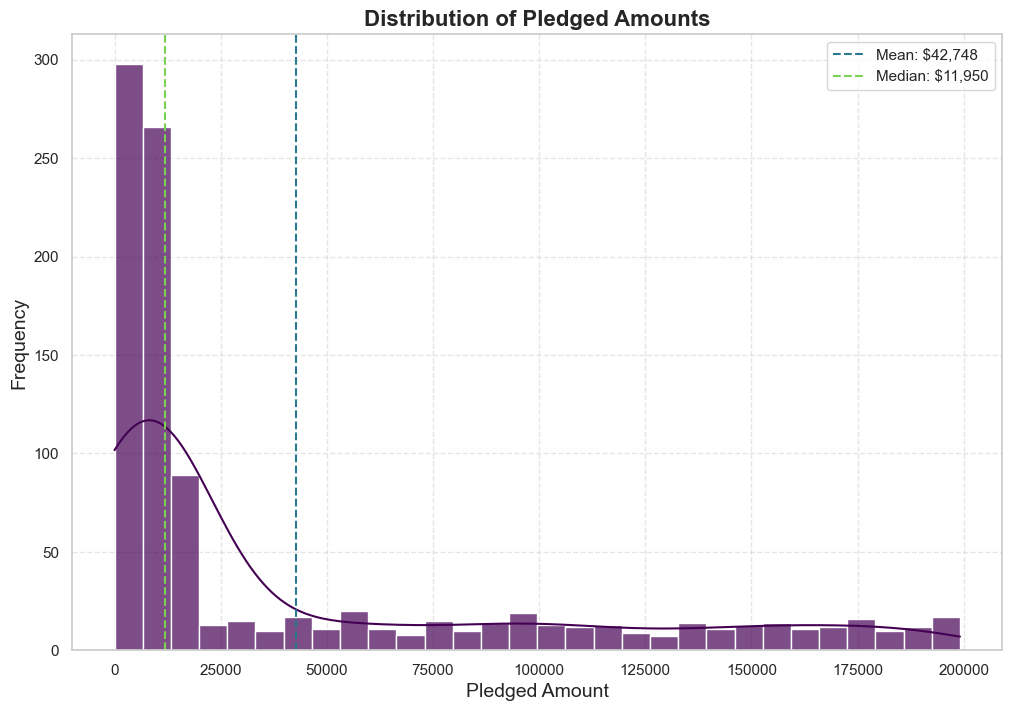

In [17]:
# Set the style and color palette of the visualization
sns.set(style="whitegrid", palette="pastel")

# Create the histogram
plt.figure(figsize=(12, 8))
hist_plot = sns.histplot(full_data_sql_df['pledged'], bins=30, kde=True, color='#440154', alpha=0.7)

# Add title and labels with improved fonts
plt.title('Distribution of Pledged Amounts', fontsize=16, fontweight='bold')
plt.xlabel('Pledged Amount', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Add grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Add annotations to show the mean and median
mean_value = full_data_sql_df['pledged'].mean()
median_value = full_data_sql_df['pledged'].median()
plt.axvline(mean_value, color='#2A788EFF', linestyle='dashed', linewidth=1.5, label=f'Mean: ${mean_value:,.0f}')
plt.axvline(median_value, color='#7AD151FF', linestyle='dashed', linewidth=1.5, label=f'Median: ${median_value:,.0f}')

# Add a legend
plt.legend()

# Show the plot
plt.show()

#### Backer by country

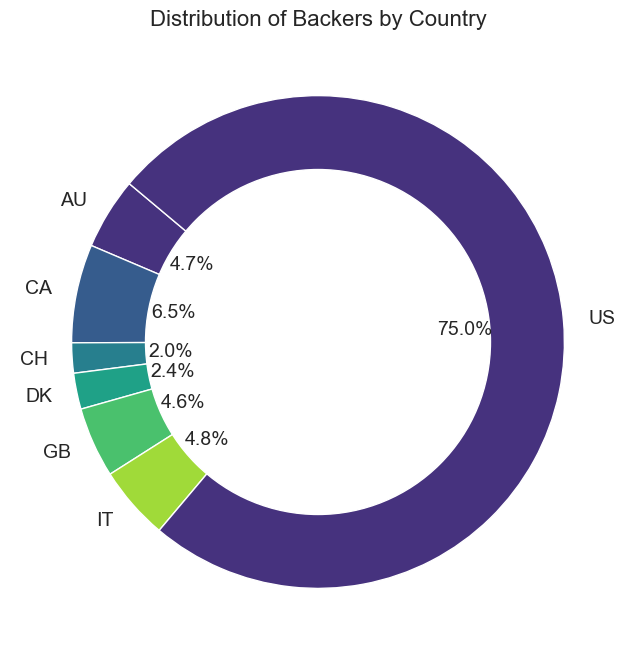

In [18]:
# Donut Chart: Distribution of backers across countries
backers_by_country_df = full_data_sql_df.groupby('country')['backers_count'].sum().reset_index()

# Define a color palette
colors = sns.color_palette('viridis')[0:len(backers_by_country_df)]

plt.figure(figsize=(8, 8))
plt.pie(backers_by_country_df['backers_count'], 
        labels=backers_by_country_df['country'], 
        autopct='%1.1f%%', 
        startangle=140, 
        colors=colors,
        textprops={'fontsize': 14}, 
        wedgeprops=dict(width=0.4, edgecolor='w'))

# Draw a white circle at the center
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Title
plt.title('Distribution of Backers by Country', fontsize=16)
plt.show()

#### Pledged by category

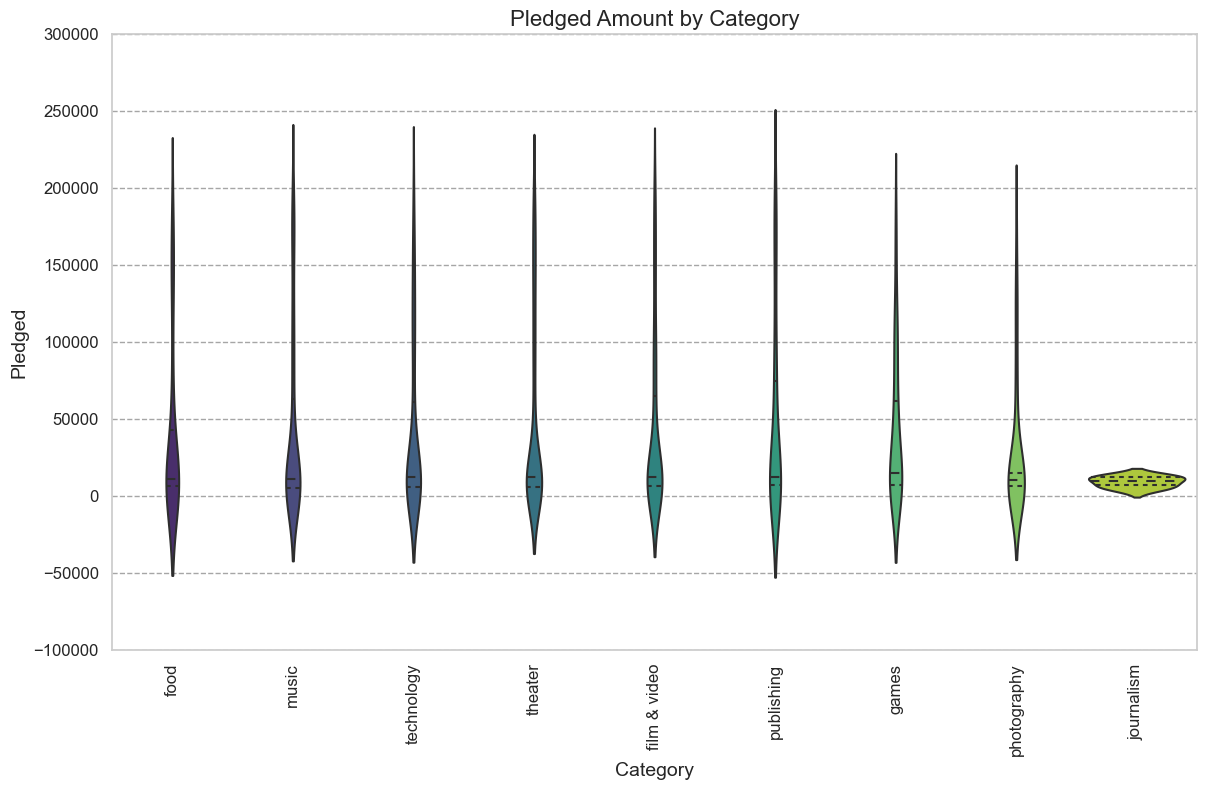

In [19]:
# Violin plot of goal vs pledged amount
# Create the canvas
plt.figure(figsize=(14, 8))

# Create the violin plot
sns.violinplot(x='category', y='pledged', data=full_data_sql_df, inner='quartile', linewidth=1.5, palette='viridis')

# Title and labels
plt.title('Pledged Amount by Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Pledged', fontsize=14)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
plt.ylim(-100000, 300000)

# Display grid lines
plt.grid(axis='y', color="gray", linestyle='--', alpha=0.7)

plt.show()

#### Goal vs Pledged

In [20]:
full_data_sql_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   first_name     1000 non-null   object        
 1   last_name      1000 non-null   object        
 2   email          1000 non-null   object        
 3   company_name   1000 non-null   object        
 4   description    1000 non-null   object        
 5   goal           1000 non-null   float64       
 6   pledged        1000 non-null   float64       
 7   outcome        1000 non-null   object        
 8   backers_count  1000 non-null   int64         
 9   country        1000 non-null   object        
 10  currency       1000 non-null   object        
 11  launched_date  1000 non-null   datetime64[ns]
 12  end_date       1000 non-null   datetime64[ns]
 13  staff_pick     1000 non-null   bool          
 14  spotlight      1000 non-null   bool          
 15  category       1000 no

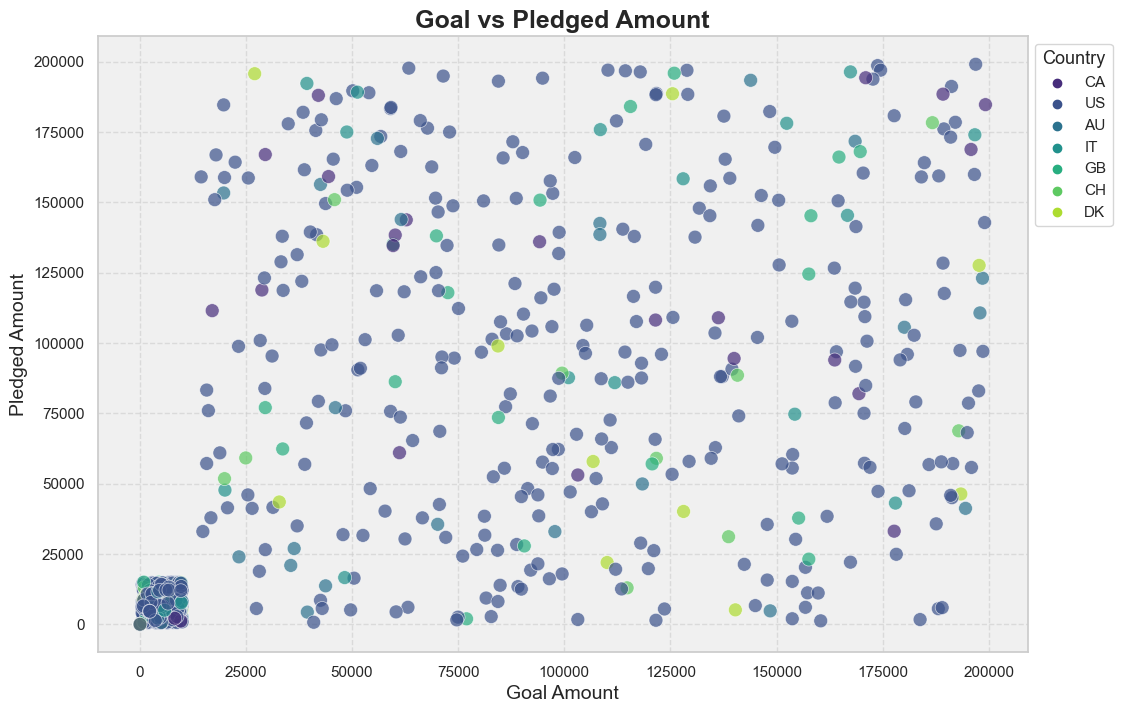

In [21]:
# Scatter Plot: Relationship between goal and pledged amount
plt.figure(figsize=(12, 8))

# Enhanced scatter plot
sns.scatterplot(x='goal', y='pledged', data=full_data_sql_df, hue='country', palette='viridis', s=100, alpha=0.7, edgecolor='w', linewidth=0.5)

# Title and labels with improved font sizes
plt.title('Goal vs Pledged Amount', fontsize=18, weight='bold')
plt.xlabel('Goal Amount', fontsize=14)
plt.ylabel('Pledged Amount', fontsize=14)

# Adding grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Legend customization
plt.legend(title='Country', title_fontsize='13', fontsize='11', loc='upper left', bbox_to_anchor=(1, 1))

# Background color
plt.gca().set_facecolor('#f0f0f0')

plt.show()

In [22]:
#Further Analysis on Denmark top pledge shown in scatter plot
query = """
        SELECT
        			camp.company_name,
        			camp.description,
        			camp.goal,
        			camp.pledged,
        			camp.outcome,
        			camp.backers_count,
        			cat.category,
        			sub.subcategory
        		FROM
        			public.campaign camp
        		JOIN public.contact cont
        			ON camp.contact_id = cont.contact_id
        		JOIN public.category cat
        			ON camp.category_id = cat.category_id
        		JOIN public.subcategory sub
        			ON camp.subcategory_id = sub.subcategory_id
        		WHERE
        			country = 'DK'
        		order by pledged desc
		;
		"""

denmark_top_pledges_df = pd.read_sql(text(query), con=engine)
denmark_top_pledges_df.head()

,company_name,description,goal,pledged,outcome,backers_count,category,subcategory
0,Adams Group,Reverse-engineered bandwidth-monitored conting...,27100.0,195750.0,successful,3318,theater,plays
1,Mitchell and Sons,Synergized intangible challenge,125500.0,188628.0,successful,1965,film & video,drama
2,"Bradley, Beck and Mayo",Synergized fault-tolerant hierarchy,43200.0,136156.0,successful,1297,publishing,translations
3,Lamb-Sanders,Stand-alone reciprocal frame,197700.0,127591.0,failed,2604,film & video,animation
4,Murillo-Mcfarland,Synchronized client-driven projection,84400.0,98935.0,successful,1052,film & video,documentary


#### Top 10 Campaigns

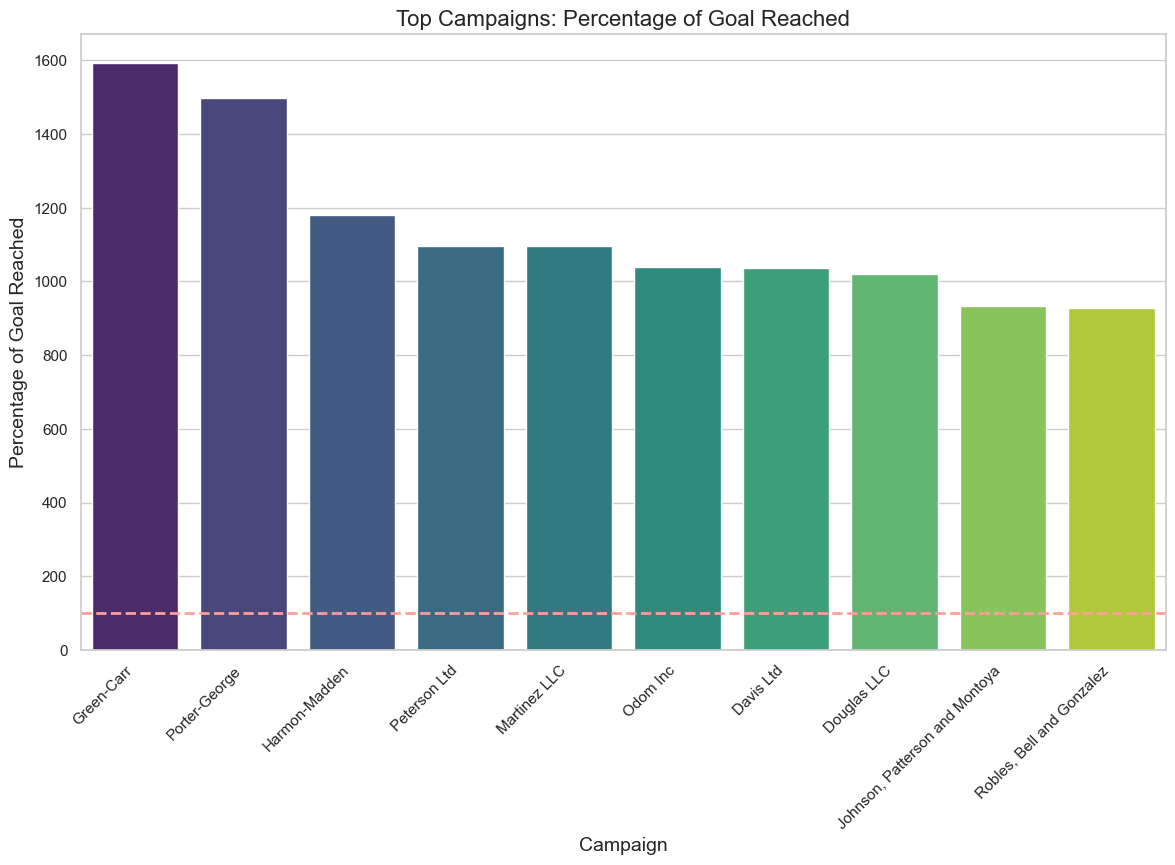

In [23]:
# Calculate percentage of goal reached
top_campaigns = 10

reached_goal_sql_df['percentage_reached'] = (reached_goal_sql_df['pledged'] / reached_goal_sql_df['goal']) * 100

# Sort and select top 10 campaigns
df_sorted = reached_goal_sql_df.sort_values(by='percentage_reached', ascending=False).head(top_campaigns)

# Progress Chart: Percentage of Goal Reached for top 10 Campaigns
plt.figure(figsize=(14, 8))
sns.barplot(x='company_name', y='percentage_reached', data=df_sorted, palette='viridis')
plt.axhline(y=100, color='r', linestyle='--', linewidth=2)
plt.title('Top Campaigns: Percentage of Goal Reached', fontsize=16)
plt.xlabel('Campaign', fontsize=14)
plt.ylabel('Percentage of Goal Reached', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.show()

#### Linear regression of goals vs pledged

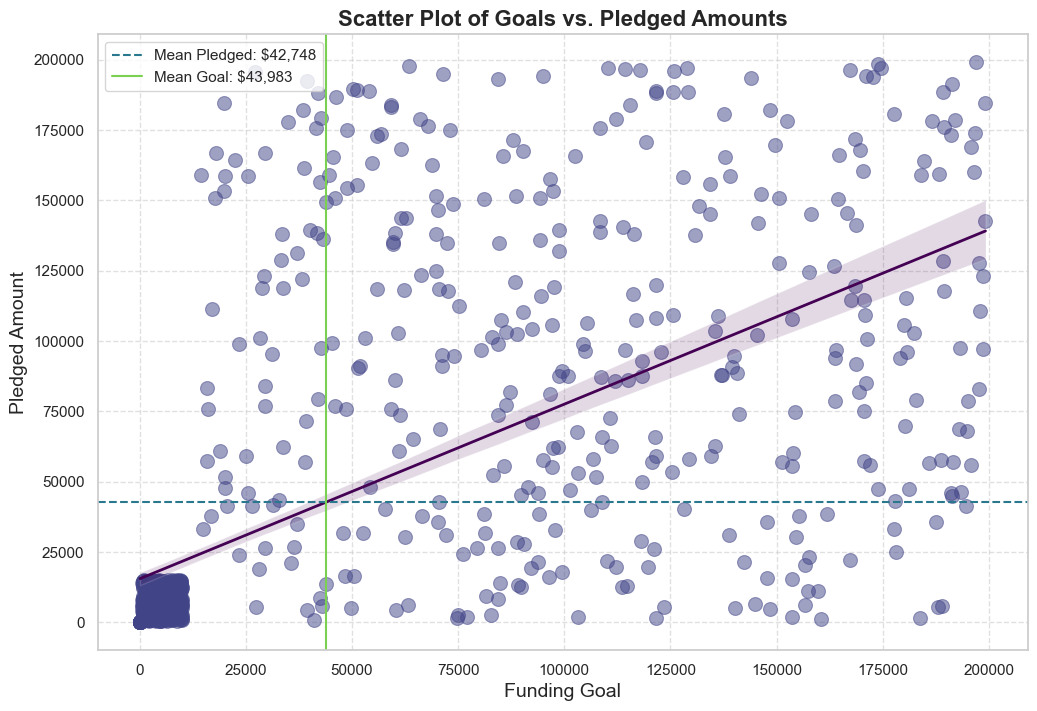

In [24]:
# Set the style and color palette of the visualization
sns.set(style="whitegrid", palette="muted")

# Create the scatter plot
plt.figure(figsize=(12, 8))
scatter_plot = sns.scatterplot(x='goal', y='pledged', data=full_data_sql_df, alpha=0.5, s=100, color='#414487FF', edgecolor=None)

# Add a regression line for trend visualization
sns.regplot(x='goal', y='pledged', data=full_data_sql_df, scatter=False, color='#440154FF', line_kws={"linewidth":2, "linestyle":"solid"})

# Set the title and labels with improved fonts
plt.title('Scatter Plot of Goals vs. Pledged Amounts', fontsize=16, fontweight='bold')
plt.xlabel('Funding Goal', fontsize=14)
plt.ylabel('Pledged Amount', fontsize=14)

# Add grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Add annotations for mean values
mean_goal = full_data_sql_df['goal'].mean()
mean_pledged = full_data_sql_df['pledged'].mean()
plt.axhline(mean_pledged, color='#2A788EFF', linestyle='dashed', linewidth=1.5, label=f'Mean Pledged: ${mean_pledged:,.0f}')
plt.axvline(mean_goal, color='#7AD151FF', linestyle='solid', linewidth=1.5, label=f'Mean Goal: ${mean_goal:,.0f}')

# Add a legend
plt.legend()

# Show the plot
plt.show()
